In [1]:
import typing
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg
import skimage

np.random.seed(2022)

def expSampleInterval(k, n_to_show):
    max_exp = math.log(k, 2)
    d = max_exp / (n_to_show - 1)
    indexes = [int(2 ** (d * i)) - 1 for i in range(n_to_show)]
    return indexes

def visualizeDigitWithLabel(digit: np.ndarray, label: int):
    plt.imshow(digit.reshape(28,28), cmap="gray")
    plt.show()
    print("The label is: ", label)

In [2]:
full_dataset = pd.read_csv("./data.csv")

print("The head of the dataset is: ")
print(full_dataset.head(5), end="\n\n")

print("The dataset has shape: ")
print(full_dataset.shape)

The head of the dataset is: 
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0

In [3]:
X = full_dataset.values[:,1:]
y = full_dataset.values[:,0]

CHOSEN_LABELS = [1, 4, 5, 6]
CHOSEN_INDEXES = np.where(np.isin(y, CHOSEN_LABELS))[0]
X = X[CHOSEN_INDEXES, :]
y = y[CHOSEN_INDEXES]

N_TRAIN = int(len(y) * 0.75)
shuffled_indexes = np.arange(len(y))
np.random.shuffle(shuffled_indexes)
X_train, y_train = X[shuffled_indexes[:N_TRAIN], :], y[shuffled_indexes[:N_TRAIN]]
X_test, y_test = X[shuffled_indexes[N_TRAIN:], :], y[shuffled_indexes[N_TRAIN:]]

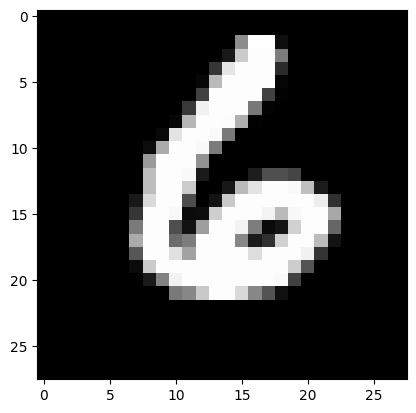

The label is:  6


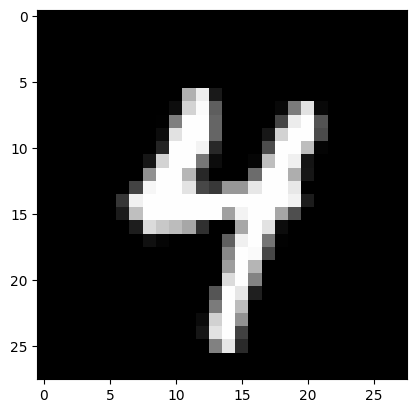

The label is:  4


In [4]:
rndidx_train = np.random.randint(0, X_train.shape[0])
rndidx_test = np.random.randint(0, X_test.shape[0])

visualizeDigitWithLabel(X_train[rndidx_train,:], y_train[rndidx_train])
visualizeDigitWithLabel(X_test[rndidx_test,:], y_test[rndidx_test])

In [5]:
def pca(X: np.ndarray, k: int = 2) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    standardized_X = X.copy()
    standardized_X = standardized_X - np.mean(X, axis=0)
    u, s, v_t = np.linalg.svd(standardized_X, full_matrices=False)
    
    # Making sure the same criteria is always applied to pick one solution
    # (i.e. make the algorithm deterministic)
    max_abs_cols = np.argmax(np.abs(u), axis=0)
    signs = np.sign(u[max_abs_cols, range(u.shape[1])])
    u *= signs
    v_t *= signs[:, np.newaxis]
    
    explained_variance_ = (s**2) / (X.shape[0] - 1)
    transformed_X = u[:,:k] * s[:k]
    
    return v_t[:k,:], explained_variance_[:k], transformed_X

def computeCentroids(X: np.ndarray, y: np.ndarray) -> typing.Tuple[np.ndarray, typing.List[int]]:
    labels = np.sort(np.unique(y))
    centroids = np.zeros((labels.shape[0], X.shape[1]), dtype=np.float32)
    for i in range(labels.shape[0]):
        centroids[i] = np.mean(X[y == labels[i]], axis=0)
    
    return centroids, list(labels)

def lda(X: np.ndarray, y: np.ndarray, k: int):
    X_c = X.copy()[np.argsort(y), :].astype("float64")
    y = np.sort(y.copy())
    
    centroids, labels = computeCentroids(X_c, y)
    global_centroid = np.mean(X_c, axis=0)
    
    s_b = np.zeros(X_c.shape, dtype=np.float64)
    
    for idx, label in enumerate(labels):
        X_c[y == label] -= centroids[idx]
        s_b[y == label, :] = centroids[idx]
        
    s_w = X_c.T @ X_c
    
    s_b -= global_centroid
    s_b = s_b.T @ s_b
    
    try:
        L = np.linalg.cholesky(s_w)
    except:
        epsilon = 1e-6
        s_w = s_w + epsilon * np.eye(s_w.shape[0])
        L = np.linalg.cholesky(s_w)

    eigvals, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ s_b @ L, k=k)
    W = np.real(W)
    eigvals = np.real(eigvals)

    Q = np.linalg.inv(L).T @ W
    Z = Q.T @ X.T
    
    return Q, Z.T

def plotClusters(data: typing.Tuple[np.ndarray, np.ndarray], centroids: np.ndarray, labels: typing.List[int], title: str = ""):
    X, y = data
    n_labels = len(labels)
    colors  = plt.cm.rainbow(np.linspace(0, 1, n_labels))
    
    for i in range(n_labels):
        plt.scatter(X[y==labels[i]][:,0], X[y==labels[i]][:,1], color=colors[i], s=10, alpha=0.2, marker=".")
    
    for i in range(n_labels):
        plt.scatter(centroids[i][0], centroids[i][1], color=colors[i] / 2., alpha=1, marker="*", label="Class {label}".format(label=labels[i]), s=80)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def avgDistancesFromCentroids(data: typing.Tuple[np.ndarray, np.ndarray], centroids: np.ndarray, labels: typing.List[int]):
    X, y = data
    n_labels = len(labels)
    
    distances = np.zeros((n_labels,), dtype=np.float32)
    for i in range(n_labels):
        distances[i] = np.mean(np.einsum("ij,ij->i", X[y==labels[i]] - centroids[i], X[y==labels[i]] - centroids[i]), axis=0)
        
    return distances

def clusteringClassifier(X: np.ndarray, centroids: np.ndarray, labels: typing.List[int]) -> np.ndarray:
    n_labels = len(labels)
    distances = np.zeros((X.shape[0], n_labels), dtype=np.float32)
    for i in range(n_labels):
        distances[:, i] = np.einsum("ij,ij->i", X - centroids[i], X - centroids[i])
    
    y_pred = np.array([labels[idx] for idx in np.argmin(distances, axis=1)])
    return y_pred

def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return sum(y_true == y_pred) / len(y_true)

In [6]:
pcs_train, explained_variance_train, pca_X_train = pca(X_train, k=2)
centroids, labels = computeCentroids(pca_X_train, y_train)

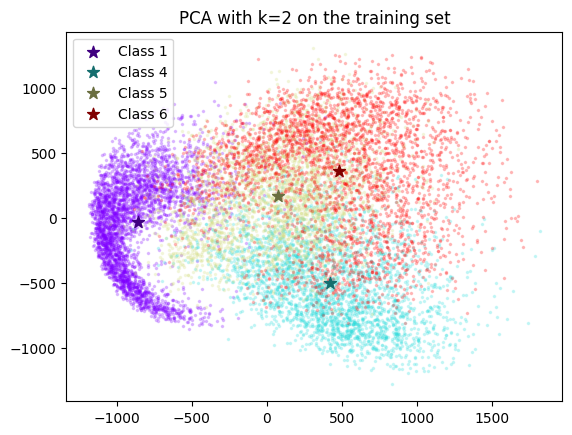

array([184732.88, 263475.9 , 258757.6 , 400979.3 ], dtype=float32)

In [7]:
plotClusters((pca_X_train, y_train), centroids=centroids, labels=labels, title="PCA with k=2 on the training set")
avgDistancesFromCentroids((pca_X_train, y_train), centroids=centroids, labels=labels)

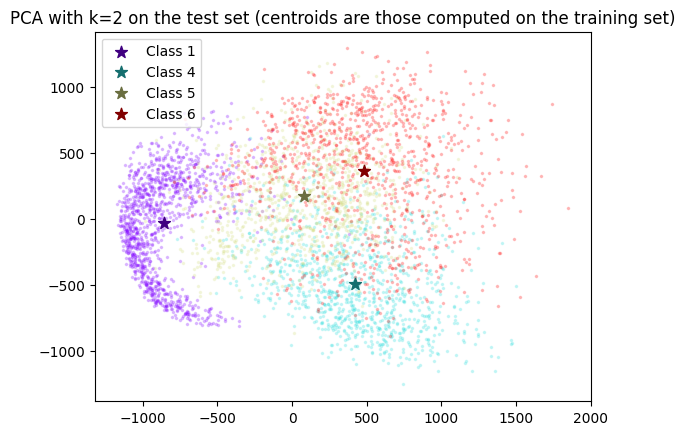

array([193882.36, 254809.25, 251005.19, 389834.16], dtype=float32)

In [8]:
pcs_test, explained_variance_test, pca_X_test = pca(X_test, k=2)
plotClusters((pca_X_test, y_test), centroids=centroids, labels=labels, 
             title="PCA with k=2 on the test set (centroids are those computed on the training set)")
avgDistancesFromCentroids((pca_X_test, y_test), centroids=centroids, labels=labels)

In [9]:
Q, lda_X_train = lda(X_train, y_train, 2)

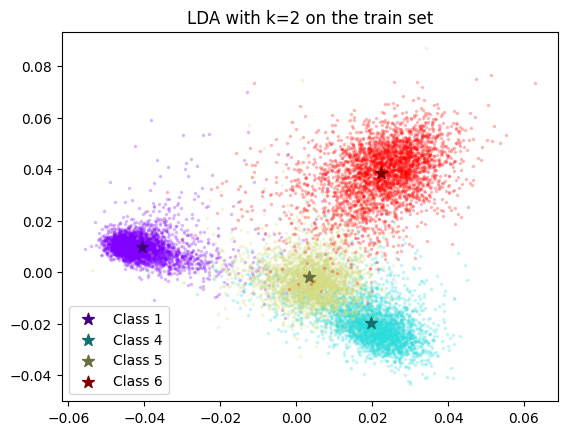

array([8.4325642e-05, 1.4887884e-04, 1.7694653e-04, 2.3958618e-04],
      dtype=float32)

In [10]:
centroids, labels = computeCentroids(lda_X_train, y_train)
plotClusters((lda_X_train, y_train), centroids, labels, "LDA with k=2 on the train set")
avgDistancesFromCentroids((lda_X_train, y_train), centroids=centroids, labels=labels)

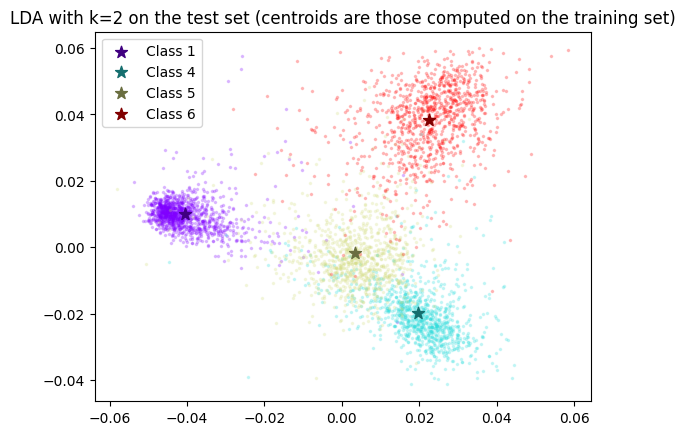

array([8.9650639e-05, 1.7513119e-04, 2.1022440e-04, 2.4641998e-04],
      dtype=float32)

In [11]:
lda_x_test = (Q.T @ X_test.T).T

# clumping only for visualization purposes
allowed_indexes = np.where(np.logical_and(np.logical_and(lda_x_test[:,0] >= -0.06, lda_x_test[:,0] <= 0.06), 
    np.logical_and(lda_x_test[:,1] >= -0.06, lda_x_test[:,1] <= 0.06)))

plotClusters((lda_x_test[allowed_indexes], y_test[allowed_indexes]), centroids=centroids, labels=labels, 
             title="LDA with k=2 on the test set (centroids are those computed on the training set)")
avgDistancesFromCentroids((lda_x_test[allowed_indexes], y_test[allowed_indexes]), centroids=centroids, labels=labels)

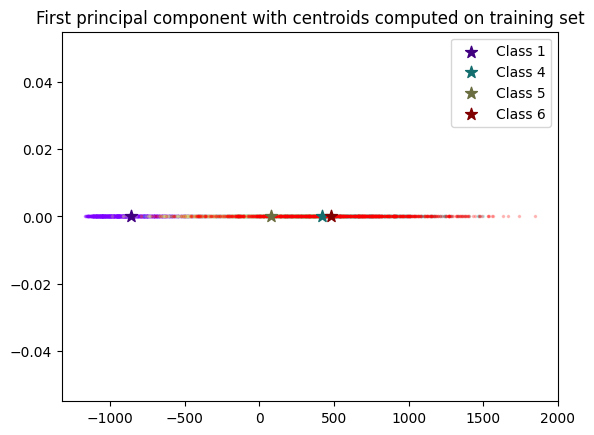

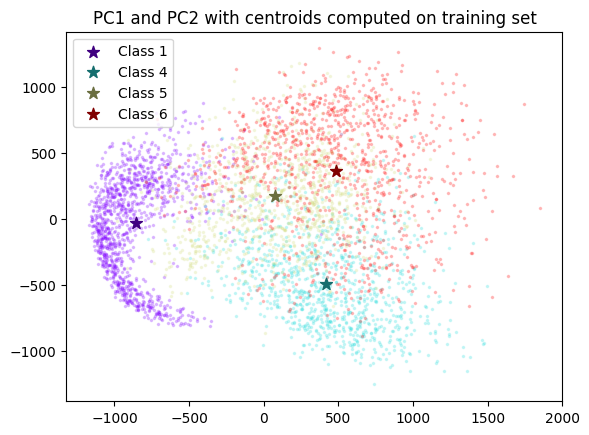

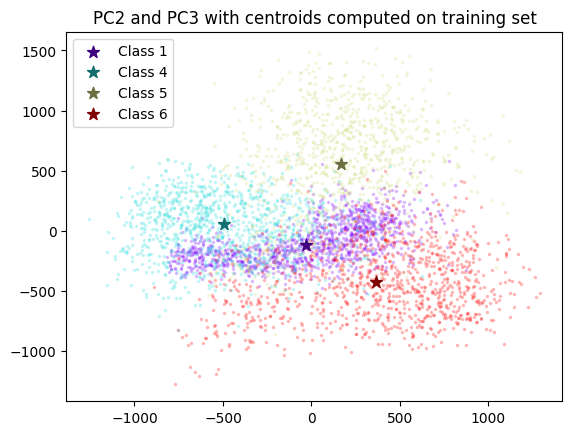

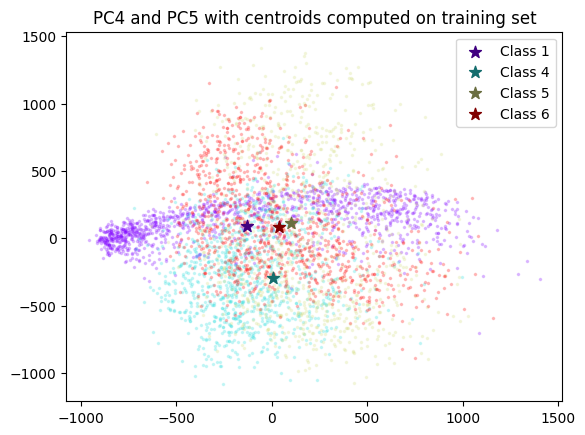

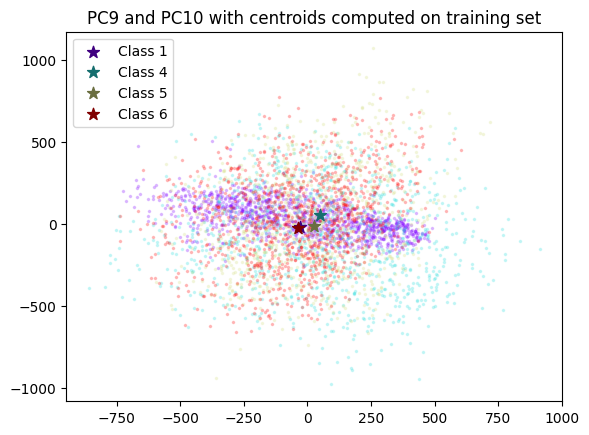

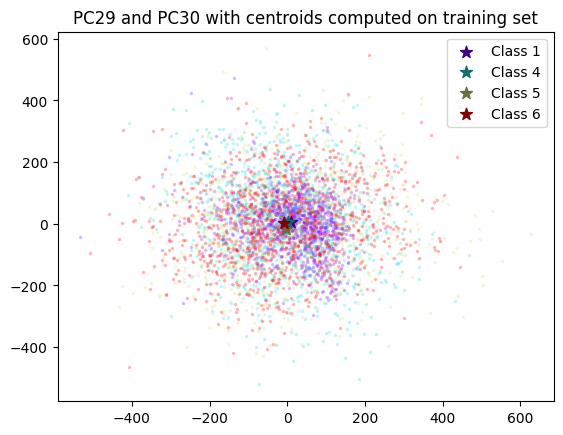

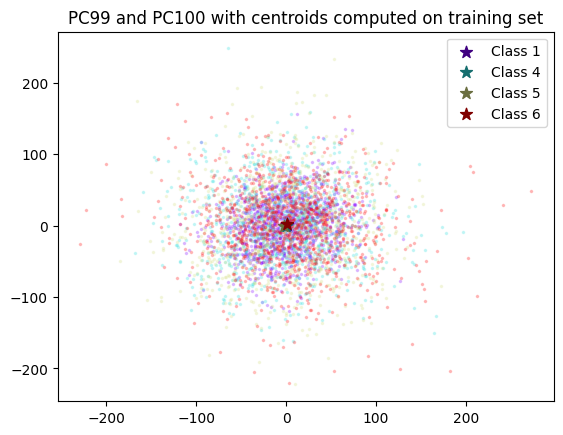

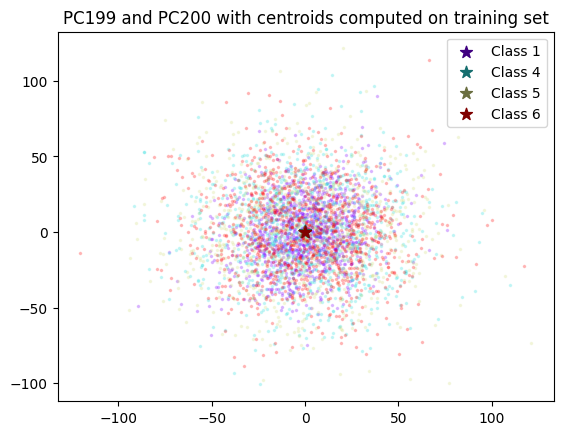

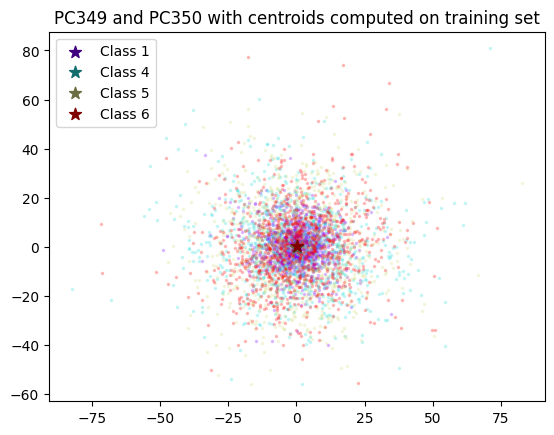

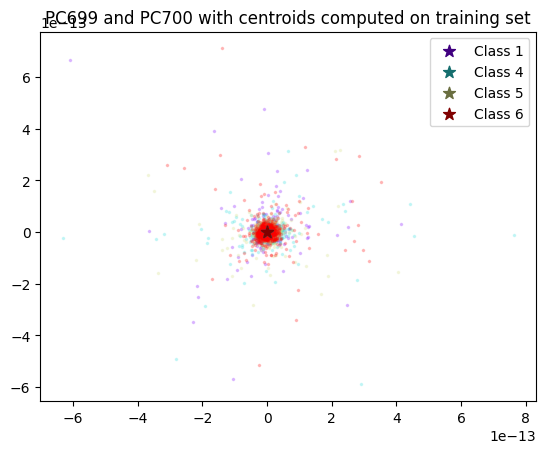

In [12]:
SHOW_PCA_BEHAVIOR_AS_K_INCREASES = True

ks = [1,2,3,5,10,30,100,200,350,700]
pca_classification_accuracy = np.zeros(len(ks), dtype = np.float32)
lda_classification_accuracy = np.zeros(len(ks), dtype = np.float32)

for idx, k in enumerate(ks):
    _, _, pca_X_train = pca(X_train, k=k)
    _, _, pca_X_test = pca(X_test, k=k)
    centroids, labels = computeCentroids(pca_X_train, y_train)
    if SHOW_PCA_BEHAVIOR_AS_K_INCREASES:
        if k >= 2:
            plotClusters((pca_X_test[:,k-2:k], y_test), centroids[:,k-2:k], labels, 
                         title="PC{k} and PC{k1} with centroids computed on training set".format(k=k-1, k1=k))
        else:
            pca_X_test_aug = np.hstack((pca_X_test.reshape((len(y_test), 1)), np.zeros((len(y_test), 1))))
            centroids_aug = np.hstack((centroids.reshape((len(labels), 1)), np.zeros((len(labels), 1))))
            plotClusters((pca_X_test_aug, y_test), centroids_aug, labels, 
                         title="First principal component with centroids computed on training set")
    y_test_pred = clusteringClassifier(pca_X_test, centroids, labels)
    pca_classification_accuracy[idx] = accuracy(y_test, y_test_pred)
    
    Q, lda_X_train = lda(X_train, y_train, k=k)
    centroids, labels = computeCentroids(lda_X_train, y_train)
    lda_X_test = (Q.T @ X_test.T).T
    y_test_pred = clusteringClassifier(lda_X_test, centroids, labels)
    lda_classification_accuracy[idx] = accuracy(y_test, y_test_pred)

In [13]:
pca_X_test[:,:2].shape

(4172, 2)

In [14]:
print(pca_classification_accuracy)
print(lda_classification_accuracy)

[0.56591564 0.72051775 0.8506711  0.8835091  0.8981304  0.900767
 0.90004796 0.90004796 0.90004796 0.90004796]
[0.6934324  0.91299134 0.95565677 0.95565677 0.95565677 0.95541704
 0.95541704 0.9549377  0.95541704 0.9542186 ]


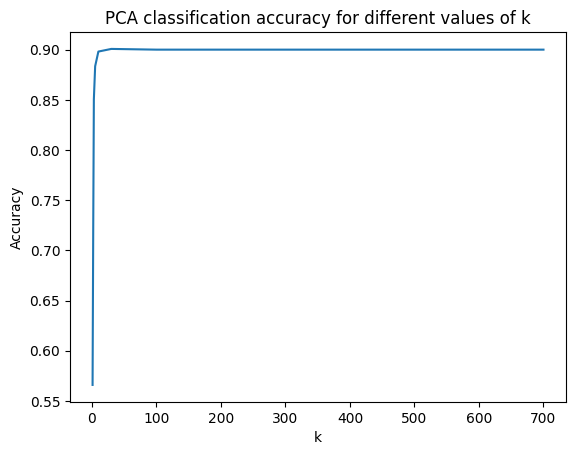

In [15]:
plt.plot(ks, pca_classification_accuracy)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("PCA classification accuracy for different values of k")
plt.show()

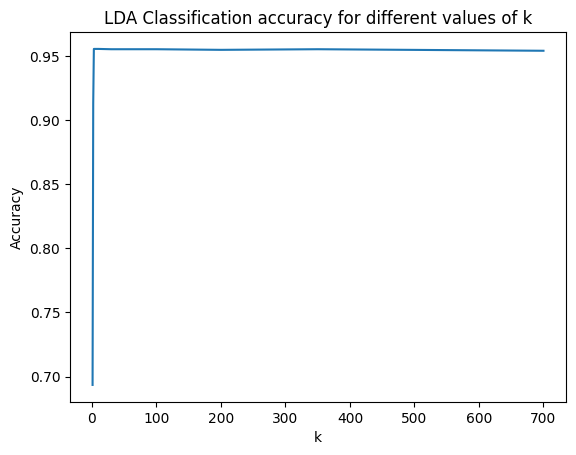

In [16]:
plt.plot(ks, lda_classification_accuracy)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("LDA Classification accuracy for different values of k")
plt.show()

## VISUALIZING DYADS

In [17]:
def kRankApproximation(u: np.ndarray, s: np.ndarray, v: np.ndarray, k: int):
    approximation = np.zeros((512, 512))
    approximation += s[i] * u[:,i].reshape(-1,1) * v[i].reshape(1,-1)
    return approximation

def plotFFT(image: np.ndarray):
    fft_img = np.fft.fftshift(np.fft.fft2(image))
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(np.log(abs(fft_img)), cmap='gray');
    plt.show()

def visualizeDyads(skimage_ref: typing.Callable):
    image_as_array: np.ndarray = skimage_ref()
    
    assert len(image_as_array.shape) == 2, "Only grayscale images are allowed"

    print("The original image is the following:")
    plt.imshow(image_as_array, cmap="gray")
    plt.show()
    
    m, n = image_as_array.shape
    k = min(m, n)
    
    u, s, v_t = np.linalg.svd(image_as_array)
    
    dyads = [s[i] * u[:,i].reshape(-1,1) * v_t[i].reshape(1,-1) for i in range(k)]
    k_rank_approximations = np.cumsum(dyads, axis=0)
    approximation_error = [np.linalg.norm(image_as_array - k_rank_approximations[i], ord=2) 
                           for i in range(k)]
    stds = [np.std(dyads[i]) for i in range(k)]
    
    selected_dyads = expSampleInterval(k, 5)
    for i in selected_dyads:
        dyad = dyads[i]
        print("dyad number %d:" % (i + 1))
        plt.imshow(dyad, cmap="gray")
        plt.show()
        print("Fourier transform of the dyad: ")
        plotFFT(dyad)
        print("\n\n")
        
        
    plt.plot(np.arange(k), stds)
    plt.xlabel("k")
    plt.ylabel("dyad standard deviation")
    plt.title("Standard deviation of the dyad's values as a function of k")
    plt.show()

    plt.plot(np.arange(k), s)
    plt.title("Singular values of X")
    plt.show()
    
    for i in selected_dyads:
        print("Now showing the {k}-rank approximation of the original image".format(k=i))
        plt.imshow(k_rank_approximations[i, :], cmap="gray")
        plt.show()
    
    plt.plot(np.arange(k), approximation_error)
    plt.ylabel("approximation error")
    plt.xlabel("k")
    plt.title("Approximation error as a function of k")
    plt.show()
    
    compression_factors = np.arange(k) / (image_as_array.shape[0] * image_as_array.shape[1])
    plt.plot(np.arange(k), compression_factors)
    plt.xlabel("k")
    plt.ylabel("compression factor")
    plt.title("Compression factor as a function of k")
    plt.show()

The original image is the following:


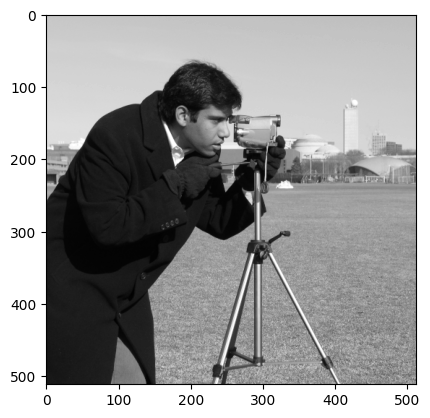

dyad number 1:


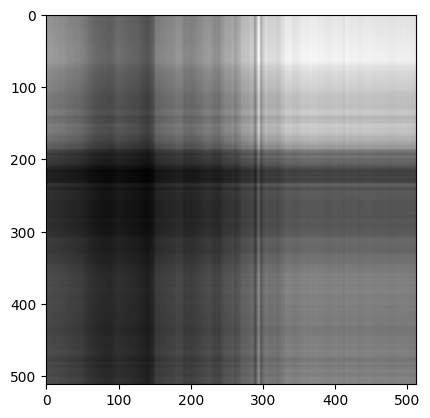

Fourier transform of the dyad: 


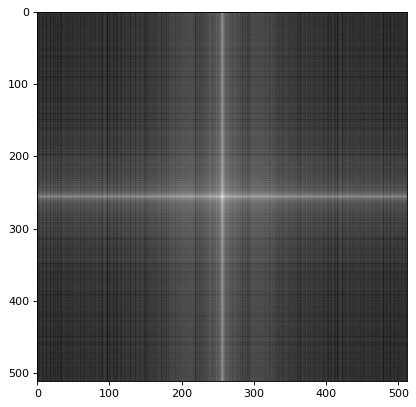




dyad number 4:


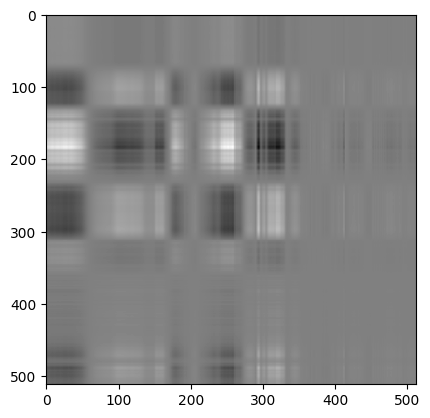

Fourier transform of the dyad: 


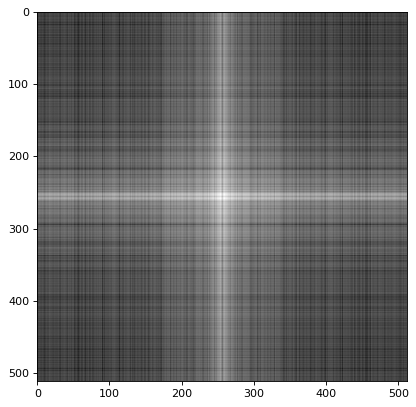




dyad number 22:


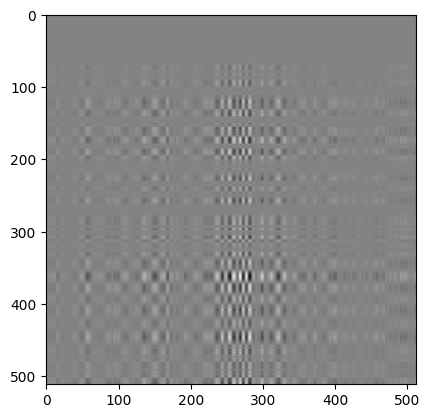

Fourier transform of the dyad: 


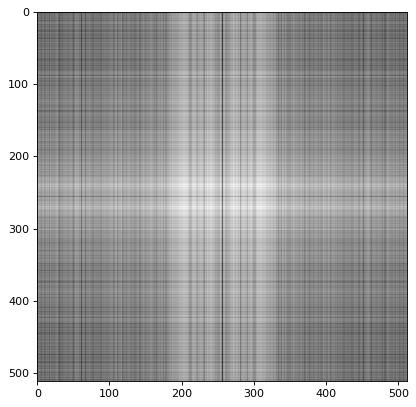




dyad number 107:


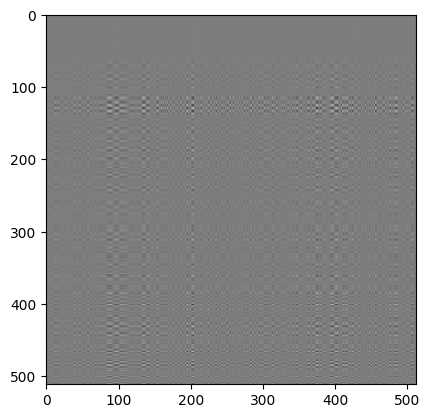

Fourier transform of the dyad: 


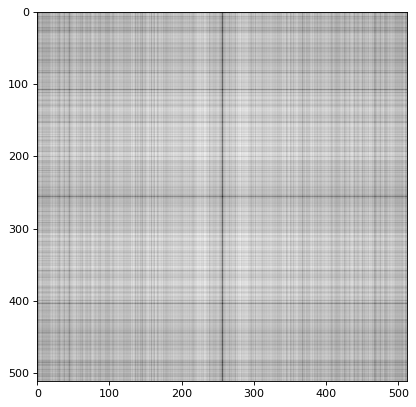




dyad number 512:


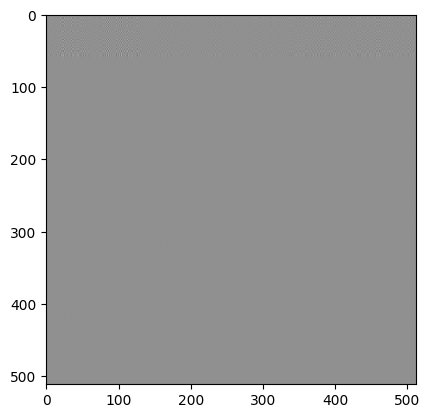

Fourier transform of the dyad: 


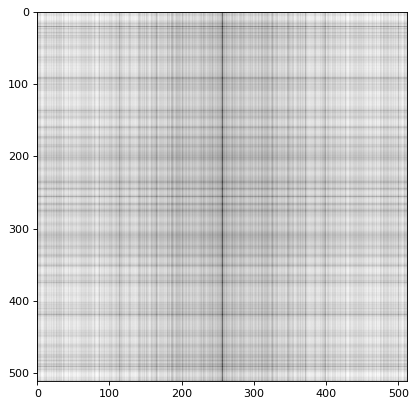

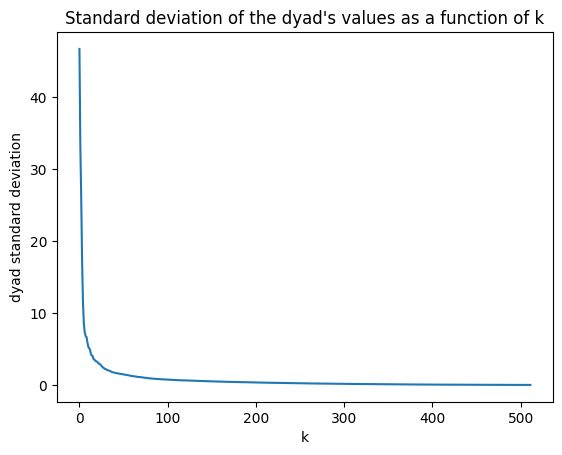

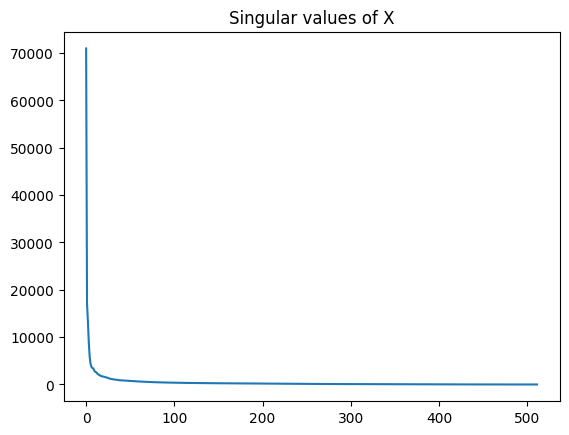

Now showing the 0-rank approximation of the original image


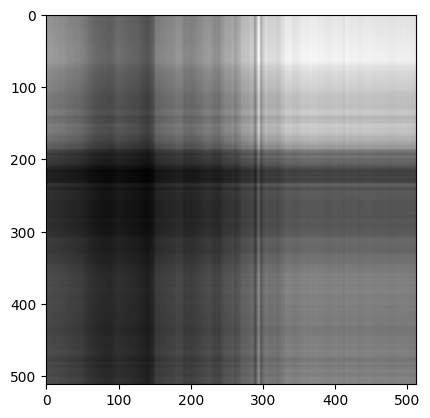

Now showing the 3-rank approximation of the original image


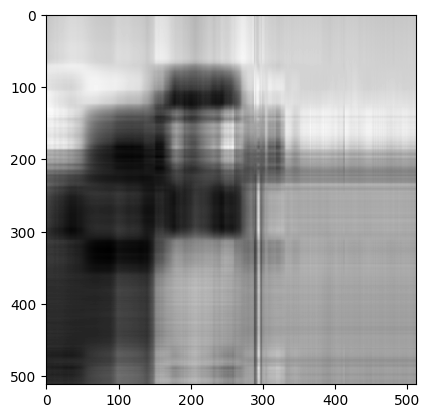

Now showing the 21-rank approximation of the original image


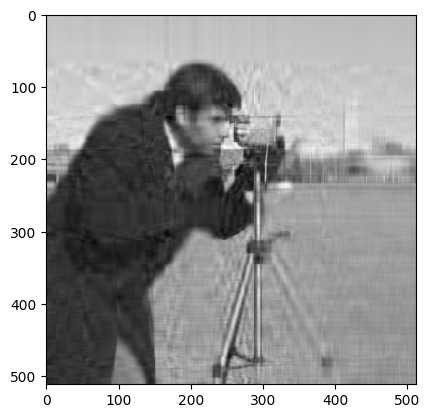

Now showing the 106-rank approximation of the original image


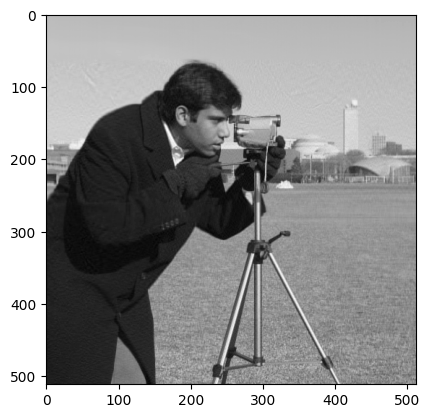

Now showing the 511-rank approximation of the original image


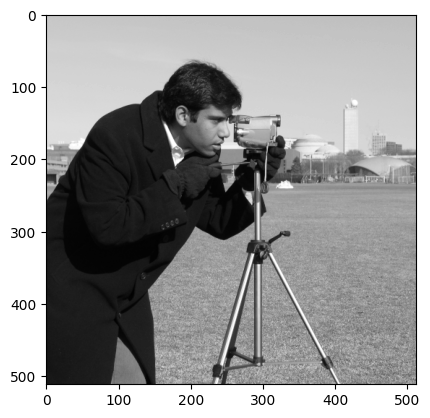

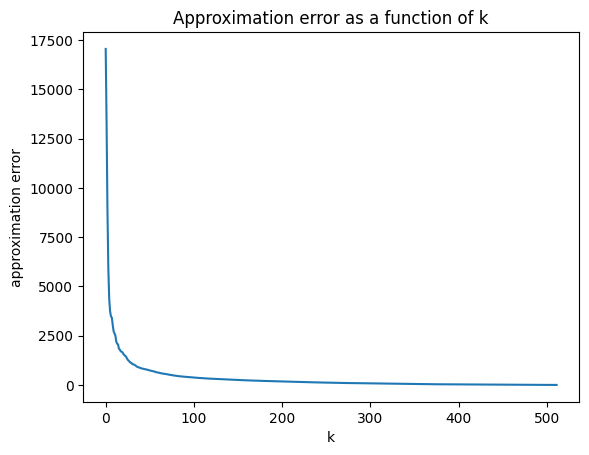

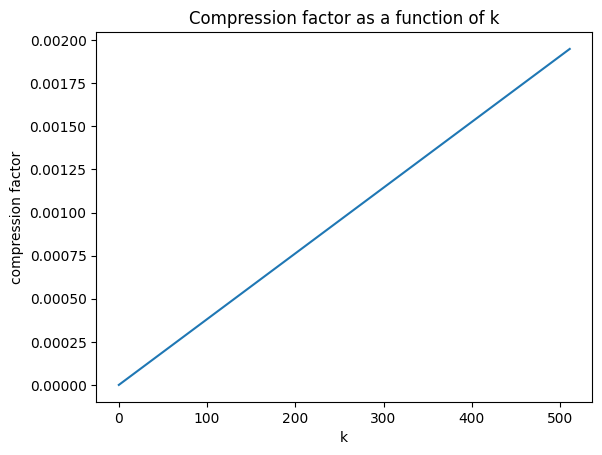

In [18]:
visualizeDyads(skimage.data.camera)